# Imports

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

from collections import defaultdict

import common_functions
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import secret
import statsmodels.api as sm
import statsmodels.formula.api as smf
import utils
from matplotlib.ticker import FormatStrFormatter
from scipy import stats
from statannotations.Annotator import Annotator
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Aim of this notebook  


1. Construct GLM models to assess the effects of potential exposure sources and effectiveness of mitigation 



In [2]:
DATA_PATH = utils.Configuration.INTERIM_DATA_PATH.joinpath(
    "HBM4EU_E-waste_template_V3_all_data_INTERIM.parquet.gzip"
)

df = pd.read_parquet(DATA_PATH)

In [3]:
columns_to_ignore = [
    "PCB 28",
    "PCB 52",
    "PCB 101",
    "BDE 28",
    "BDE 47",
    "BDE 99",
    "BDE 100",
    "BDE 153",
    "BDE 154",
    "BDE 183",
    "BDE 209",
    "Dechlorane",
]

df_GLM = (
    df.loc[:, lambda df: ~df.columns.isin(columns_to_ignore)]
    .rename(columns=lambda df: df.replace(" ", "_"))
    .assign(
        how_many_km=lambda df: df.how_many_km.fillna(20),
        cigarette_smoking=lambda df: df.cigarette_smoking.fillna(
            df.cigarette_smoking.value_counts().index[0]
        ),
        years_smoked=lambda df: df.years_smoked.fillna(0),
        cigarettes_per_day=lambda df: df.cigarettes_per_day.mask(
            df.cigarette_smoking == "Former smoker", 0
        ).mask(df.cigarette_smoking == "No", 0),
        former_smoker_years_ago_stopped=lambda df: df.former_smoker_years_ago_stopped.fillna(
            0
        ),
        former_smoker_cigatette_a_day=lambda df: df.former_smoker_cigatette_a_day.fillna(
            0
        ),
        former_smoker_for_how_many_years=lambda df: df.former_smoker_for_how_many_years.fillna(
            0
        ),
        Tonnes=lambda df: df.Tonnes.replace({"No": 0}).astype(float)
        # .fillna(0)
    )
    .assign(
        PCB_118=lambda df: df.PCB_118.fillna(df.PCB_118.min()),
        PCB_138=lambda df: df.PCB_138.fillna(df.PCB_118.min()),
        PCB_153=lambda df: df.PCB_153.fillna(df.PCB_118.min()),
        PCB_180=lambda df: df.PCB_180.fillna(
            df.PCB_118.min(),
        ),
        Tonnes=lambda df: df["Tonnes"].fillna(
            df.groupby("sub_category")["Tonnes"].transform("median")
        ),
        Age_binned=lambda df: pd.cut(
            df.Age,
            bins=[17, 30, 40, 50, 65],
            labels=[
                "Between 18 and 30",
                "Between 30 and 40",
                "Between 40 and 50",
                "Over 50",
            ],
            right=True,
        ).astype(object),
        BMI_binned=lambda df: pd.cut(
            df.BMI,
            bins=[17, 18.5, 25, 30, 45],
            labels=["underweight", "healthy", "overweight", "obese"],
            right=True,
        ).astype(object),
        years_worked_binned=lambda df: pd.cut(
            df.years_worked,
            bins=[-1, 5, 15, 25],
            labels=[
                "less than 5",
                "between 5 and 15",
                "over 15",
            ],
            right=True,
        ).astype(object),
    )
    .fillna(0)
)

C:\Users\s0212777\AppData\Local\anaconda3\envs\HBM4EU\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\s0212777\AppData\Local\anaconda3\envs\HBM4EU\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


<Axes: xlabel='variable'>

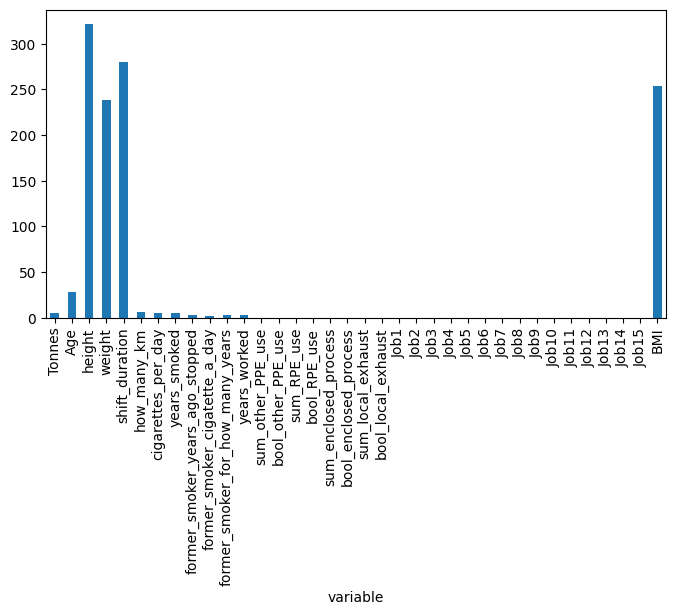

In [4]:
variables_to_test_1 = df_GLM.drop(
    columns=["PCB_118", "PCB_138", "PCB_153", "PCB_180"]
).select_dtypes("number")

vif_1 = pd.DataFrame()
vif_1["VIF"] = [
    variance_inflation_factor(variables_to_test_1.values, i)
    for i in range(variables_to_test_1.shape[1])
]
vif_1["variable"] = variables_to_test_1.columns
vif_1.set_index("variable").plot.bar(legend=False, figsize=(8, 4))

<Axes: xlabel='variable'>

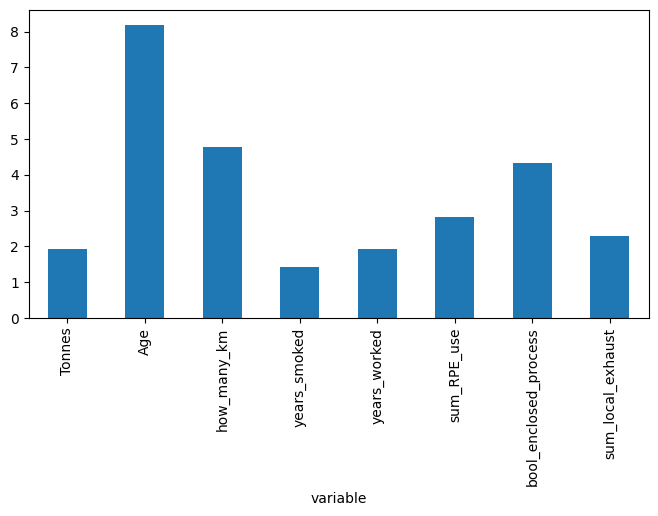

In [5]:
variables_to_test_2 = df_GLM.loc[
    :,
    lambda df: df.columns.isin(
        [
            "Tonnes",
            "Age",
            "how_many_km",
            "years_smoked",
            "years_worked",
            "sum_RPE_use",
            "bool_enclosed_process",
            "sum_local_exhaust",
            # "industrial_plants_in_surroundings",
            # "sub_category",
            # "Sex",
            # "home_location",
        ]
    ),
]
vif_2 = pd.DataFrame()
vif_2["VIF"] = [
    variance_inflation_factor(variables_to_test_2.values, i)
    for i in range(variables_to_test_2.shape[1])
]
vif_2["variable"] = variables_to_test_2.columns
vif_2.set_index("variable").plot.bar(legend=False, figsize=(8, 4))

### PCB-138

#### Identify outliers

0.4495558560852887
46


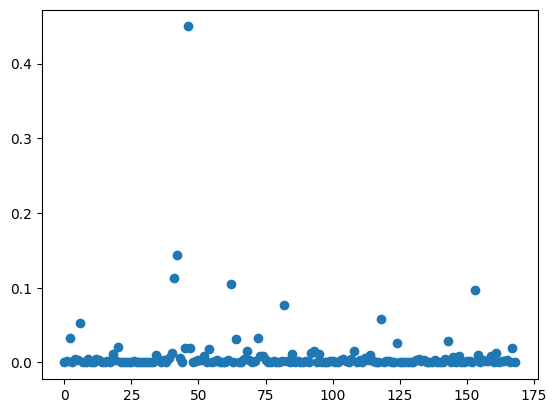

In [6]:
formula = "np.sqrt(PCB_138) ~ Tonnes  + Age + how_many_km + years_smoked + years_worked +\
sum_RPE_use + C(bool_enclosed_process) + sum_local_exhaust +  C(industrial_plants_in_surroundings) + C(sub_category) + C(Sex) + C(home_location)"

model = smf.glm(
    formula=formula,
    data=df_GLM,
    family=sm.families.Gamma(link=sm.families.links.log()),
).fit()

"""
The Cook's distance is considered high if it is greater than 0.5 and extreme if it is greater than 1
"""

plt.scatter(range(df_GLM.shape[0]), model.get_influence().cooks_distance[0])

print(np.max(model.get_influence().cooks_distance[0]))
print(np.argmax(model.get_influence().cooks_distance[0]))

#### Build GLM model

In [7]:
formula = "np.sqrt(PCB_138) ~ Tonnes  + Age +  how_many_km + years_smoked + years_worked +\
sum_RPE_use + C(bool_enclosed_process, Treatment(reference=0)) + sum_local_exhaust +  C(industrial_plants_in_surroundings, Treatment(reference=False)) + C(sub_category, Treatment(reference='outwith_CTR'))\
+ C(Sex, Treatment(reference='Female')) + C(home_location, Treatment(reference='Rural')) "

df_GLM_outlier_removed = df_GLM.drop(index=secret.SECRET.exclude_from_model)

model_PCB138 = smf.glm(
    formula=formula,
    data=df_GLM_outlier_removed,
    family=sm.families.Gamma(link=sm.families.links.log()),
).fit()
model_PCB138.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       np.sqrt(PCB_138)   No. Observations:                  168
Model:                            GLM   Df Residuals:                      150
Model Family:                   Gamma   Df Model:                           17
Link Function:                    log   Scale:                         0.18085
Method:                          IRLS   Log-Likelihood:                -421.73
Date:                Mon, 30 Oct 2023   Deviance:                       34.424
Time:                        10:52:50   Pearson chi2:                     27.1
No. Iterations:                    23   Pseudo R-squ. (CS):             0.3818
Covariance Type:            nonrobust                                         
==============================================================================================================================================
                                                                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                      1.2018      0.642      1.871      0.061      -0.057       2.460
C(bool_enclosed_process, Treatment(reference=0))[T.1.0]                       -0.0785      0.166     -0.473      0.636      -0.404       0.247
C(industrial_plants_in_surroundings, Treatment(reference=False))[T.True]      -0.2449      0.535     -0.458      0.647      -1.294       0.804
C(sub_category, Treatment(reference='outwith_CTR'))[T.Batteries]               0.6686      0.250      2.671      0.008       0.178       1.159
C(sub_category, Treatment(reference='outwith_CTR'))[T.Brown goods]             0.6362      0.244      2.610      0.009       0.158       1.114
C(sub_category, Treatment(reference='outwith_CTR'))[T.Metals and plastics]     0.7303      0.198      3.685      0.000       0.342       1.119
C(sub_category, Treatment(reference='outwith_CTR'))[T.Miscellaneous]           0.6660      0.220      3.029      0.002       0.235       1.097
C(sub_category, Treatment(reference='outwith_CTR'))[T.White goods]             1.0857      0.300      3.619      0.000       0.498       1.674
C(sub_category, Treatment(reference='outwith_CTR'))[T.within_CTR]              0.7223      0.203      3.565      0.000       0.325       1.119
C(Sex, Treatment(reference='Female'))[T.Male]                                  0.0899      0.094      0.961      0.337      -0.093       0.273
C(home_location, Treatment(reference='Rural'))[T.Urban]                        0.0074      0.083      0.089      0.929      -0.155       0.170
Tonnes                                                                     -7.931e-06   5.39e-06     -1.471      0.141   -1.85e-05    2.64e-06
Age                                                                            0.0150      0.004      4.075      0.000       0.008       0.022
how_many_km                                                                   -0.0172      0.031     -0.557      0.578      -0.078       0.043
years_smoked                                                                   0.0045      0.003      1.442      0.149      -0.002       0.011
years_worked                                                                   0.0061      0.005      1.128      0.259      -0.005       0.017
sum_RPE_use                                                                   -0.0165      0.025     -0.665      0.506      -0.065       0.032
sum_local_exhaust                                                             -0.1968      0.066     -2.965      0.003      -0.327      -0.067
================================================================================

Shapiro-Wilk test statistic: 0.9831172227859497
Shapiro-Wilk test p-value: 0.0390399806201458


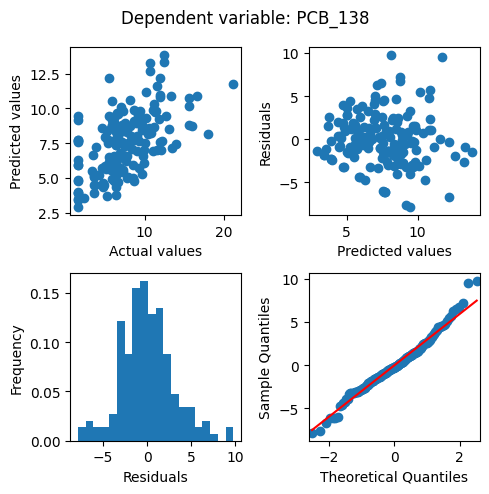

In [8]:
common_functions.plot_diagnostics(
    df=df_GLM_outlier_removed,
    model=model_PCB138,
    dependent_variable="PCB_138",
    save_to_disk=True,
)

### PCB-153
#### Identify outliers

0.6493577516993021
46


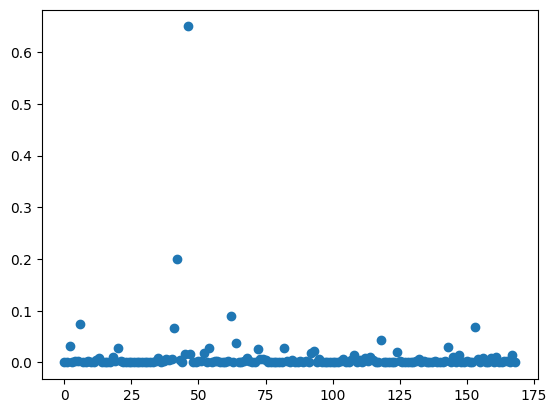

In [9]:
formula = "np.sqrt(PCB_153) ~ Tonnes  + Age + how_many_km + years_smoked + years_worked +\
sum_RPE_use + C(bool_enclosed_process) + sum_local_exhaust +  C(industrial_plants_in_surroundings) + C(sub_category) + C(Sex) + C(home_location)"

model = smf.glm(
    formula=formula,
    data=df_GLM,
    family=sm.families.Gamma(link=sm.families.links.log()),
).fit()

plt.scatter(range(df_GLM.shape[0]), model.get_influence().cooks_distance[0])

print(np.max(model.get_influence().cooks_distance[0]))
print(np.argmax(model.get_influence().cooks_distance[0]))

#### Build GLM model

In [10]:
formula = "np.sqrt(PCB_153) ~ Tonnes  + Age +  how_many_km + years_smoked + years_worked +\
sum_RPE_use + C(bool_enclosed_process, Treatment(reference=0)) + sum_local_exhaust +  C(industrial_plants_in_surroundings, Treatment(reference=False)) + C(sub_category, Treatment(reference='outwith_CTR'))\
+ C(Sex, Treatment(reference='Female')) + C(home_location, Treatment(reference='Rural')) "

df_GLM_outlier_removed = df_GLM.drop(index=secret.SECRET.exclude_from_model)

model_PCB153 = smf.glm(
    formula=formula,
    data=df_GLM_outlier_removed,
    family=sm.families.Gamma(link=sm.families.links.log()),
).fit()
model_PCB153.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       np.sqrt(PCB_153)   No. Observations:                  168
Model:                            GLM   Df Residuals:                      150
Model Family:                   Gamma   Df Model:                           17
Link Function:                    log   Scale:                         0.19558
Method:                          IRLS   Log-Likelihood:                -498.53
Date:                Mon, 30 Oct 2023   Deviance:                       42.980
Time:                        10:52:52   Pearson chi2:                     29.3
No. Iterations:                    26   Pseudo R-squ. (CS):             0.4275
Covariance Type:            nonrobust                                         
==============================================================================================================================================
                                                                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                      1.4265      0.668      2.136      0.033       0.118       2.735
C(bool_enclosed_process, Treatment(reference=0))[T.1.0]                       -0.1221      0.173     -0.707      0.480      -0.461       0.216
C(industrial_plants_in_surroundings, Treatment(reference=False))[T.True]      -0.2407      0.556     -0.433      0.665      -1.331       0.850
C(sub_category, Treatment(reference='outwith_CTR'))[T.Batteries]               0.8559      0.260      3.289      0.001       0.346       1.366
C(sub_category, Treatment(reference='outwith_CTR'))[T.Brown goods]             0.6990      0.254      2.757      0.006       0.202       1.196
C(sub_category, Treatment(reference='outwith_CTR'))[T.Metals and plastics]     0.8385      0.206      4.068      0.000       0.435       1.242
C(sub_category, Treatment(reference='outwith_CTR'))[T.Miscellaneous]           0.7236      0.229      3.165      0.002       0.276       1.172
C(sub_category, Treatment(reference='outwith_CTR'))[T.White goods]             1.1945      0.312      3.829      0.000       0.583       1.806
C(sub_category, Treatment(reference='outwith_CTR'))[T.within_CTR]              0.7641      0.211      3.627      0.000       0.351       1.177
C(Sex, Treatment(reference='Female'))[T.Male]                                  0.1181      0.097      1.214      0.225      -0.073       0.309
C(home_location, Treatment(reference='Rural'))[T.Urban]                       -0.0045      0.086     -0.052      0.958      -0.173       0.164
Tonnes                                                                     -7.931e-06   5.61e-06     -1.415      0.157   -1.89e-05    3.06e-06
Age                                                                            0.0173      0.004      4.525      0.000       0.010       0.025
how_many_km                                                                   -0.0170      0.032     -0.529      0.597      -0.080       0.046
years_smoked                                                                   0.0045      0.003      1.396      0.163      -0.002       0.011
years_worked                                                                   0.0069      0.006      1.225      0.221      -0.004       0.018
sum_RPE_use                                                                   -0.0311      0.026     -1.203      0.229      -0.082       0.020
sum_local_exhaust                                                             -0.2297      0.069     -3.326      0.001      -0.365      -0.094
================================================================================

Shapiro-Wilk test statistic: 0.9900632500648499
Shapiro-Wilk test p-value: 0.2900683879852295


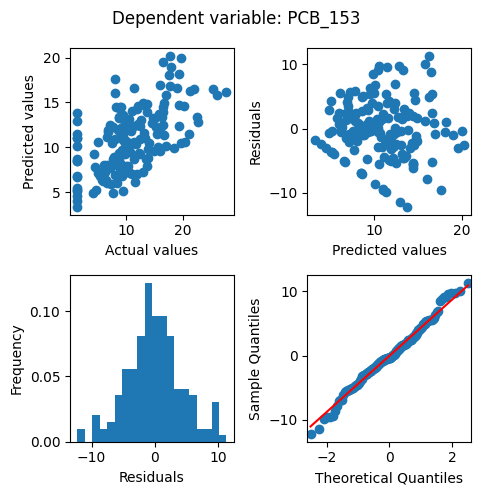

In [11]:
common_functions.plot_diagnostics(
    df=df_GLM_outlier_removed,
    model=model_PCB153,
    dependent_variable="PCB_153",
    save_to_disk=True,
)

### PCB-180
#### Identify outliers

0.5169770431141327
46


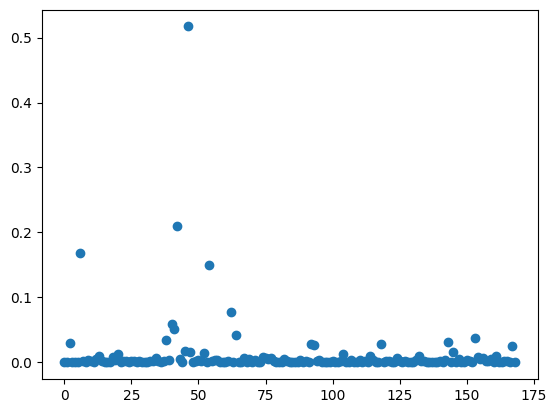

In [12]:
formula = "np.sqrt(PCB_180) ~ Tonnes  + Age + how_many_km + years_smoked + years_worked +\
sum_RPE_use + C(bool_enclosed_process) + sum_local_exhaust +  C(industrial_plants_in_surroundings) + C(sub_category) + C(Sex) + C(home_location)"

model = smf.glm(
    formula=formula,
    data=df_GLM,
    family=sm.families.Gamma(link=sm.families.links.log()),
).fit()

plt.scatter(range(df_GLM.shape[0]), model.get_influence().cooks_distance[0])

print(np.max(model.get_influence().cooks_distance[0]))
print(np.argmax(model.get_influence().cooks_distance[0]))

#### Build GLM model

In [13]:
formula = "np.sqrt(PCB_180) ~ Tonnes  + Age +  how_many_km + years_smoked + years_worked +\
sum_RPE_use + C(bool_enclosed_process, Treatment(reference=0)) + sum_local_exhaust +  C(industrial_plants_in_surroundings, Treatment(reference=False)) + C(sub_category, Treatment(reference='outwith_CTR'))\
+ C(Sex, Treatment(reference='Female')) + C(home_location, Treatment(reference='Rural')) "

df_GLM_outlier_removed = df_GLM.drop(index=secret.SECRET.exclude_from_model)

model_PCB180 = smf.glm(
    formula=formula,
    data=df_GLM_outlier_removed,
    family=sm.families.Gamma(link=sm.families.links.log()),
).fit()
model_PCB180.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       np.sqrt(PCB_180)   No. Observations:                  168
Model:                            GLM   Df Residuals:                      150
Model Family:                   Gamma   Df Model:                           17
Link Function:                    log   Scale:                         0.20606
Method:                          IRLS   Log-Likelihood:                -456.25
Date:                Mon, 30 Oct 2023   Deviance:                       40.214
Time:                        10:52:56   Pearson chi2:                     30.9
No. Iterations:                    23   Pseudo R-squ. (CS):             0.5398
Covariance Type:            nonrobust                                         
==============================================================================================================================================
                                                                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                      0.7534      0.685      1.099      0.272      -0.590       2.097
C(bool_enclosed_process, Treatment(reference=0))[T.1.0]                        0.0503      0.177      0.284      0.776      -0.297       0.398
C(industrial_plants_in_surroundings, Treatment(reference=False))[T.True]      -0.1003      0.571     -0.176      0.861      -1.220       1.019
C(sub_category, Treatment(reference='outwith_CTR'))[T.Batteries]               0.7998      0.267      2.994      0.003       0.276       1.323
C(sub_category, Treatment(reference='outwith_CTR'))[T.Brown goods]             0.6837      0.260      2.627      0.009       0.174       1.194
C(sub_category, Treatment(reference='outwith_CTR'))[T.Metals and plastics]     0.7276      0.212      3.439      0.001       0.313       1.142
C(sub_category, Treatment(reference='outwith_CTR'))[T.Miscellaneous]           0.6743      0.235      2.873      0.004       0.214       1.134
C(sub_category, Treatment(reference='outwith_CTR'))[T.White goods]             1.1566      0.320      3.612      0.000       0.529       1.784
C(sub_category, Treatment(reference='outwith_CTR'))[T.within_CTR]              0.8778      0.216      4.059      0.000       0.454       1.302
C(Sex, Treatment(reference='Female'))[T.Male]                                  0.1610      0.100      1.613      0.107      -0.035       0.357
C(home_location, Treatment(reference='Rural'))[T.Urban]                       -0.0211      0.088     -0.238      0.812      -0.194       0.152
Tonnes                                                                     -6.877e-06   5.75e-06     -1.195      0.232   -1.82e-05     4.4e-06
Age                                                                            0.0209      0.004      5.331      0.000       0.013       0.029
how_many_km                                                                   -0.0071      0.033     -0.214      0.831      -0.072       0.058
years_smoked                                                                   0.0048      0.003      1.439      0.150      -0.002       0.011
years_worked                                                                   0.0072      0.006      1.250      0.211      -0.004       0.019
sum_RPE_use                                                                   -0.0340      0.027     -1.278      0.201      -0.086       0.018
sum_local_exhaust                                                             -0.2312      0.071     -3.263      0.001      -0.370      -0.092
================================================================================

Shapiro-Wilk test statistic: 0.988901674747467
Shapiro-Wilk test p-value: 0.21032485365867615


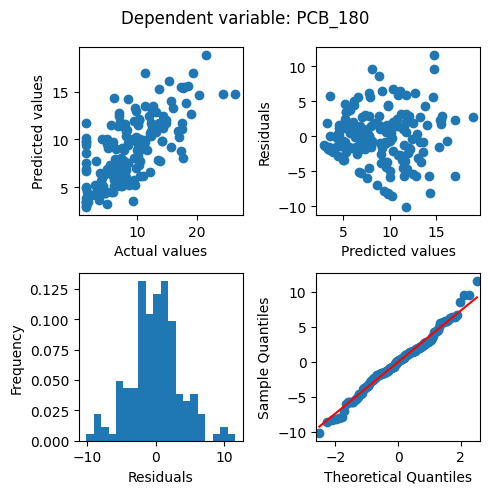

In [14]:
common_functions.plot_diagnostics(
    df=df_GLM_outlier_removed,
    model=model_PCB180,
    dependent_variable="PCB_180",
    save_to_disk=True,
)

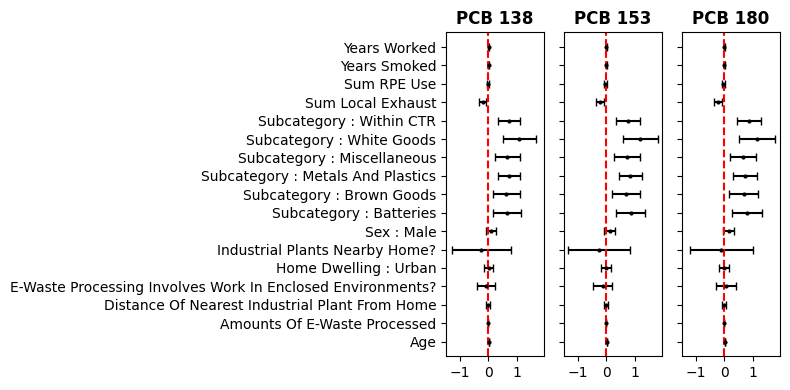

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(8, 4), sharey=True, sharex=True)
models = {"model1": model_PCB138, "model2": model_PCB153, "model3": model_PCB180}
for t, (k, u) in zip(range(0, 3), models.items()):
    temp = (
        u.summary2()
        .tables[1]
        .iloc[1:, :]
        .rename(
            index={
                "Sum rpe use": "Sum RPE use",
                "C(bool_enclosed_process, Treatment(reference=0))[T.1.0]": "E-waste processing involves work in enclosed environments?",
                "C(industrial_plants_in_surroundings, Treatment(reference=False))[T.True]": "Industrial plants nearby home?",
                "C(sub_category, Treatment(reference='outwith_CTR'))[T.Batteries]": "Subcategory : Batteries",
                "C(sub_category, Treatment(reference='outwith_CTR'))[T.Brown goods]": "Subcategory : Brown goods",
                "C(sub_category, Treatment(reference='outwith_CTR'))[T.Metals and plastics]": "Subcategory : Metals and plastics",
                "C(sub_category, Treatment(reference='outwith_CTR'))[T.Miscellaneous]": "Subcategory : Miscellaneous",
                "C(sub_category, Treatment(reference='outwith_CTR'))[T.White goods]": "Subcategory : White goods",
                "C(Sex, Treatment(reference='Female'))[T.Male]": "Sex : Male",
                "C(sub_category, Treatment(reference='outwith_CTR'))[T.within_CTR]": "Subcategory : Within CTR",
                "C(home_location, Treatment(reference='Rural'))[T.Urban]": "Home dwelling : Urban",
                "Tonnes": "Amounts of e-waste processed",
                "how_many_km": "Distance of nearest industrial plant from home",
            }
        )
        .rename(index=lambda x: x.replace("_", " ").title())
        .rename(
            index={
                "Sum Rpe Use": "Sum RPE Use",
                "Subcategory : Within Ctr": "Subcategory : Within CTR",
            }
        )
        .sort_index()
    )
    (
        temp.pipe(
            lambda df: axs[t].errorbar(
                y=df.index,
                x=df["Coef."],
                xerr=df["Std.Err."]
                * 1.959964,  # std error is converted to CI https://stats.stackexchange.com/questions/512789/converting-between-confidence-interval-and-standard-error
                ls="None",
                capsize=3,
                markersize=2,
                ecolor="black",
                fmt="o",
                c="black",
            )
        )
    )

for ax in axs:
    ax.axvline(x=0, linestyle="dashed", color="red")

axs[0].set_title("PCB 138", fontweight="bold", fontsize=12)
axs[1].set_title("PCB 153", fontweight="bold", fontsize=12)
axs[2].set_title("PCB 180", fontweight="bold", fontsize=12)

plt.tight_layout()

plt.savefig(utils.Configuration.PLOTS.joinpath("img3.png"), dpi=600)